In [91]:
import contextily
import geopandas as gpd 
import rioxarray as rxr
import seaborn as sns
import pandas as pd
from libpysal.weights import Queen, Rook, KNN
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from pysal.lib import cg as geometry
from crime_patterns.analysis import point_patterns 
from crime_patterns.analysis import spatial_regression

In [145]:
np.random.seed(1)
# Get points in a grid
data_points = np.arange(3)
x_coords, y_coords = np.meshgrid(data_points, data_points)

polygons = []
# Generate polygons
for x, y in zip(x_coords.flatten(), y_coords.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polygons.append(poly)

# Convert to GeoSeries
polygons = gpd.GeoSeries(polygons)
gdf = gpd.GeoDataFrame(
    {
        "geometry": polygons,
        "ID": [f"{str(i).zfill(2)}" for i in range(len(polygons))],
        "crime_count": np.random.randint(100, 350, size=len(polygons)),
        "pop_count": np.random.randint(15000, 45000, size=len(polygons)),
        "EmpScore": np.random.uniform(0.039, 0.0667, size=len(polygons)),
        "IncScore": np.random.uniform(0.054, 0.0937, size=len(polygons)),
        "BHSScore": np.random.uniform(23.68, 26.58, size=len(polygons)),
    }
)

In [169]:
db = pd.DataFrame(
    {
        "ID": [f"{str(i).zfill(2)}" for i in range(len(polygons))],
        "crime_count": np.random.randint(100, 350, size=len(polygons)),
        "pop_count": np.random.randint(15000, 45000, size=len(polygons)),
        "EmpScore": np.random.uniform(0.039, 0.0667, size=len(polygons)),
        "IncScore": np.random.uniform(0.054, 0.0937, size=len(polygons)),
        "BHSScore": np.random.uniform(23.68, 26.58, size=len(polygons)),
    }
)

In [174]:
db["crime_rate"] = db["crime_count"] / db["pop_count"]

In [175]:
db

,ID,crime_count,pop_count,EmpScore,IncScore,BHSScore,geometry,crime_rate
0,00,137,15144,0.047678,0.084902,23.851805,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0.009046
1,01,335,35609,0.053530,0.082424,25.624531,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....",0.009408
2,02,240,31332,0.051284,0.085869,25.399890,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",0.007660
3,03,172,22751,0.045359,0.057684,25.627797,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.007560
4,04,237,25989,0.053803,0.074571,24.874185,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....",0.009119
5,05,303,18462,0.064317,0.088341,24.252898,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",0.016412
6,06,233,40778,0.051665,0.086917,24.519926,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",0.005714
7,07,179,36780,0.050930,0.086935,24.092148,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",0.004867
8,08,292,36758,0.065014,0.064840,25.951612,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",0.007944


In [155]:
db_num = db.select_dtypes(include='number')
db_num = (db_num - db_num.mean()) / db_num.std()
db[db_num.columns] = db_num

In [170]:
gdf = gpd.GeoDataFrame(
    db,
    geometry = polygons
)

<Axes: >

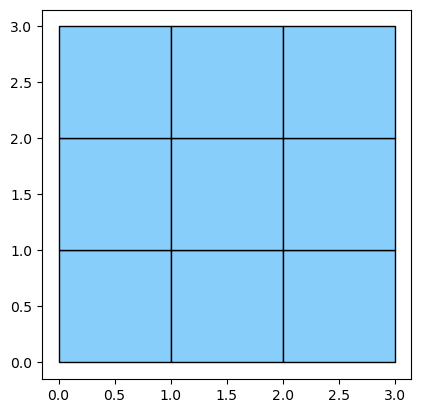

In [171]:
gdf.plot(ec="k", fc="lightskyblue")

In [172]:
gdf

,ID,crime_count,pop_count,EmpScore,IncScore,BHSScore,geometry
0,00,137,15144,0.047678,0.084902,23.851805,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
1,01,335,35609,0.053530,0.082424,25.624531,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2...."
2,02,240,31332,0.051284,0.085869,25.399890,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3...."
3,03,172,22751,0.045359,0.057684,25.627797,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1...."
4,04,237,25989,0.053803,0.074571,24.874185,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2...."
5,05,303,18462,0.064317,0.088341,24.252898,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3...."
6,06,233,40778,0.051665,0.086917,24.519926,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1...."
7,07,179,36780,0.050930,0.086935,24.092148,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
8,08,292,36758,0.065014,0.064840,25.951612,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3...."


In [173]:
W = KNN.from_dataframe(gdf, k=8)

In [160]:
# W = spatial_regression.create_weights_matrix(gdf, method="knn", k=8)

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated an

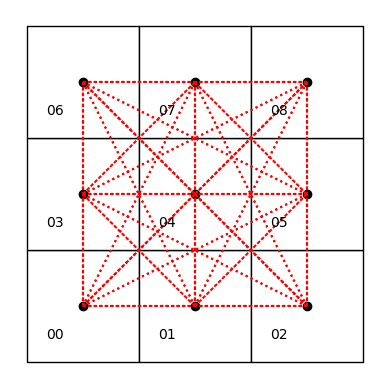

In [161]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip([p.centroid.x - 0.25 for p in polygons], [p.centroid.y - 0.25 for p in polygons], list(gdf["ID"])):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
W.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

In [162]:
moran = spatial_regression.calculate_morans_I(gdf, "crime_count", W)

In [163]:
moran.I

-0.125

In [164]:
import numpy as np
from shapely.geometry import Point, Polygon

def _create_random_points_within_bounds(poly, number):   
    
    np.random.seed(1)
    minx, miny, maxx, maxy = poly.bounds

    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )

    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    
    return gpd.GeoDataFrame(df, geometry='points')

In [179]:
gdf

,ID,crime_count,pop_count,EmpScore,IncScore,BHSScore,geometry,crime_rate
0,00,137,15144,0.047678,0.084902,23.851805,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0.009046
1,01,335,35609,0.053530,0.082424,25.624531,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....",0.009408
2,02,240,31332,0.051284,0.085869,25.399890,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",0.007660
3,03,172,22751,0.045359,0.057684,25.627797,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.007560
4,04,237,25989,0.053803,0.074571,24.874185,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....",0.009119
5,05,303,18462,0.064317,0.088341,24.252898,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",0.016412
6,06,233,40778,0.051665,0.086917,24.519926,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",0.005714
7,07,179,36780,0.050930,0.086935,24.092148,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",0.004867
8,08,292,36758,0.065014,0.064840,25.951612,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",0.007944


In [181]:
model_ols = spatial_regression.perform_spatial_regression(db=gdf, y_var_name="crime_rate", x_var_names=["EmpScore", "IncScore", "BHSScore"])


In [186]:
model_ols.betas

array([[ 0.02170552],
       [ 0.29654963],
       [-0.01118001],
       [-0.00112875]])

In [188]:
output_expected = np.array([[ 0.02170552],
        [ 0.29654963],
        [-0.01118001],
        [-0.00112875]])

In [190]:
np.testing.assert_array_almost_equal(model_ols.betas, output_expected, decimal=4)

In [165]:
points = [
    _create_random_points_within_bounds(row["geometry"], int(row["crime_count"]))
    for i, row in gdf.iterrows()
]

ValueError: negative dimensions are not allowed

In [139]:
gdf_points_2 = pd.concat(points)

<Axes: >

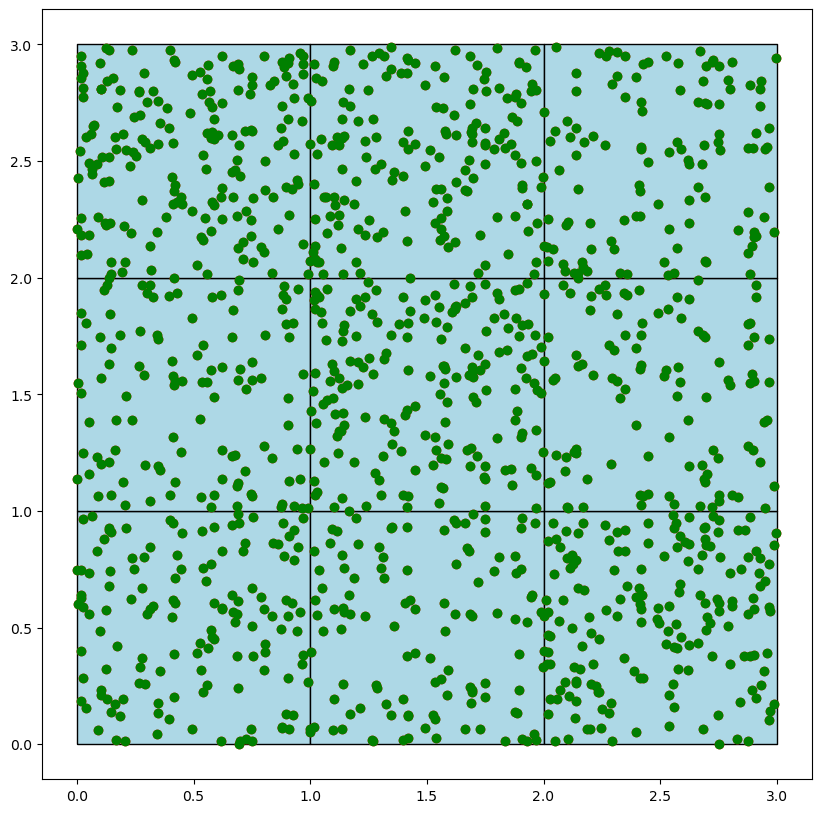

In [140]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_polygons.plot(ax=ax, color="lightblue", ec="k")
gdf_points.plot(ax=ax, color="red")
gdf_points_2.plot(ax=ax, color="green")

In [ ]:
db = burglary_ward.copy()
db_num = pd.DataFrame(db.select_dtypes(include='number'))
db_num = (db_num - db_num.mean()) / db_num.std()
db[db_num.columns] = db_num